In [43]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
from run import main

In [44]:
"""
    start_time: the start time of the simulation (can only be used when you have saved state at that given timestamp)
    finish_time: the total simulation time
    checkpoints: a list of simulation timestamp for state saving e.g. [1000, 5000, 7000]
    scheme: simultaneously, randomly, alternatively, None
"""
metrics = main(start_time=0, finish_time=5000, checkpoints=[1000, 3000, 5000, 7000], scheme='alternatively')

Adversary: Start SCAN_HOST at 0.0s.
MTD: CompleteTopologyShuffle triggered 0.0s
MTD: CompleteTopologyShuffle deployed in the network at 0.0s.
Adversary: Processed SCAN_HOST at 10.0s.
Adversary: Start ENUM_HOST at 10.0s.
Adversary: Processed ENUM_HOST at 25.0s.
Adversary: Start SCAN_PORT at 25.0s.
MTD: HostTopologyShuffle triggered 30.8s
MTD: HostTopologyShuffle suspended at 30.8s due to resource occupation
Adversary: Processed SCAN_PORT at 45.0s.
Adversary: Start EXPLOIT_VULN at 45.0s.
MTD: CompleteTopologyShuffle finished in 50.5s at 50.5s.
MTD: Interrupted EXPLOIT_VULN at 50.5s!
Adversary: Restarting with SCAN_HOST at 60.5s!
Adversary: Start SCAN_HOST at 60.5s.
MTD: HostTopologyShuffle triggered 62.0s
MTD: HostTopologyShuffle deployed in the network at 62.0s.
Adversary: Processed SCAN_HOST at 70.5s.
Adversary: Start ENUM_HOST at 70.5s.
Adversary: Processed ENUM_HOST at 85.5s.
Adversary: Start SCAN_PORT at 85.5s.
MTD: IPShuffle triggered 92.0s
MTD: IPShuffle suspended at 92.0s due to 

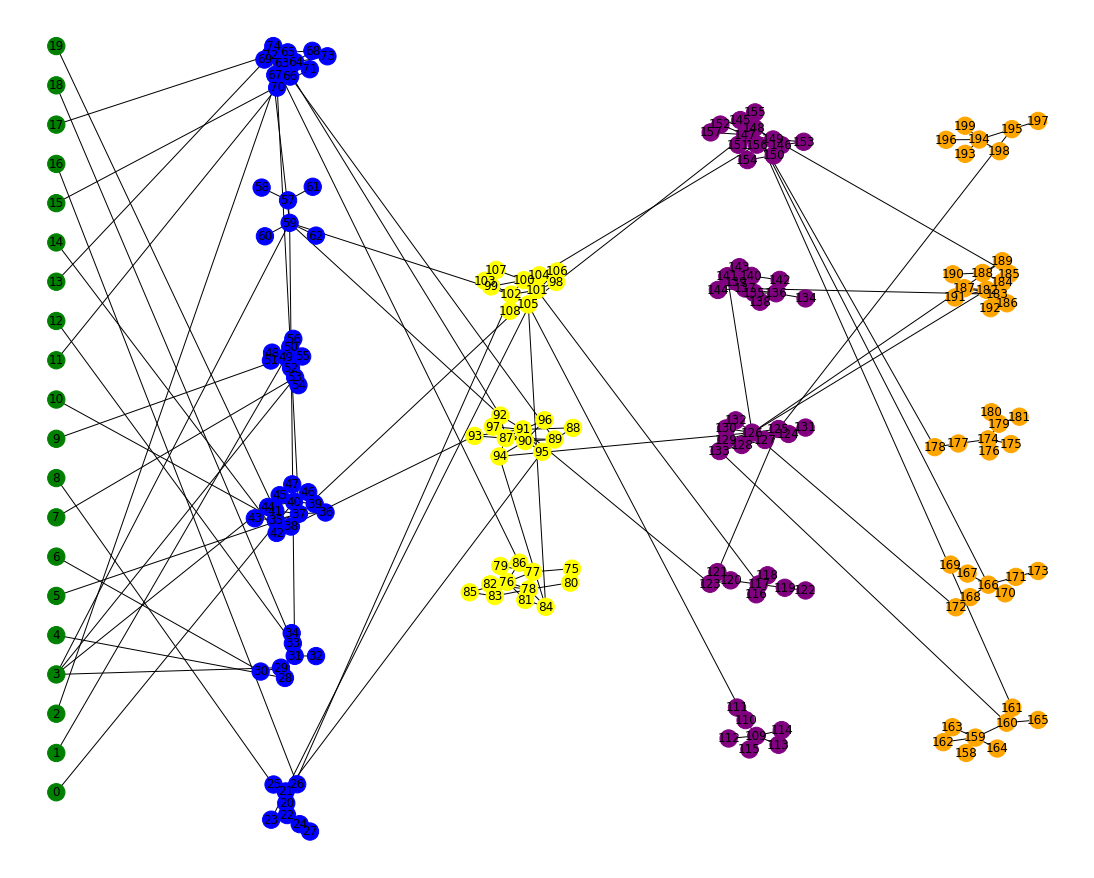

In [45]:
metrics.draw_network()

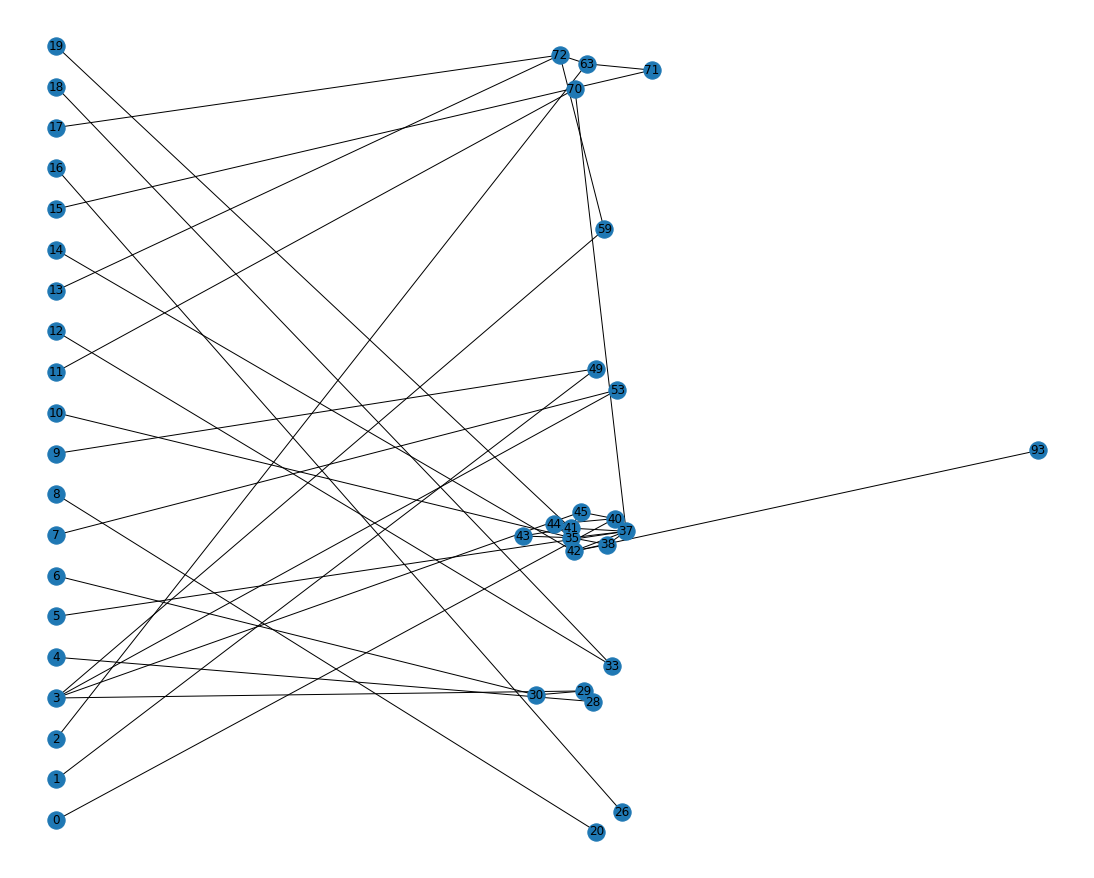

In [46]:
metrics.draw_hacker_visible()

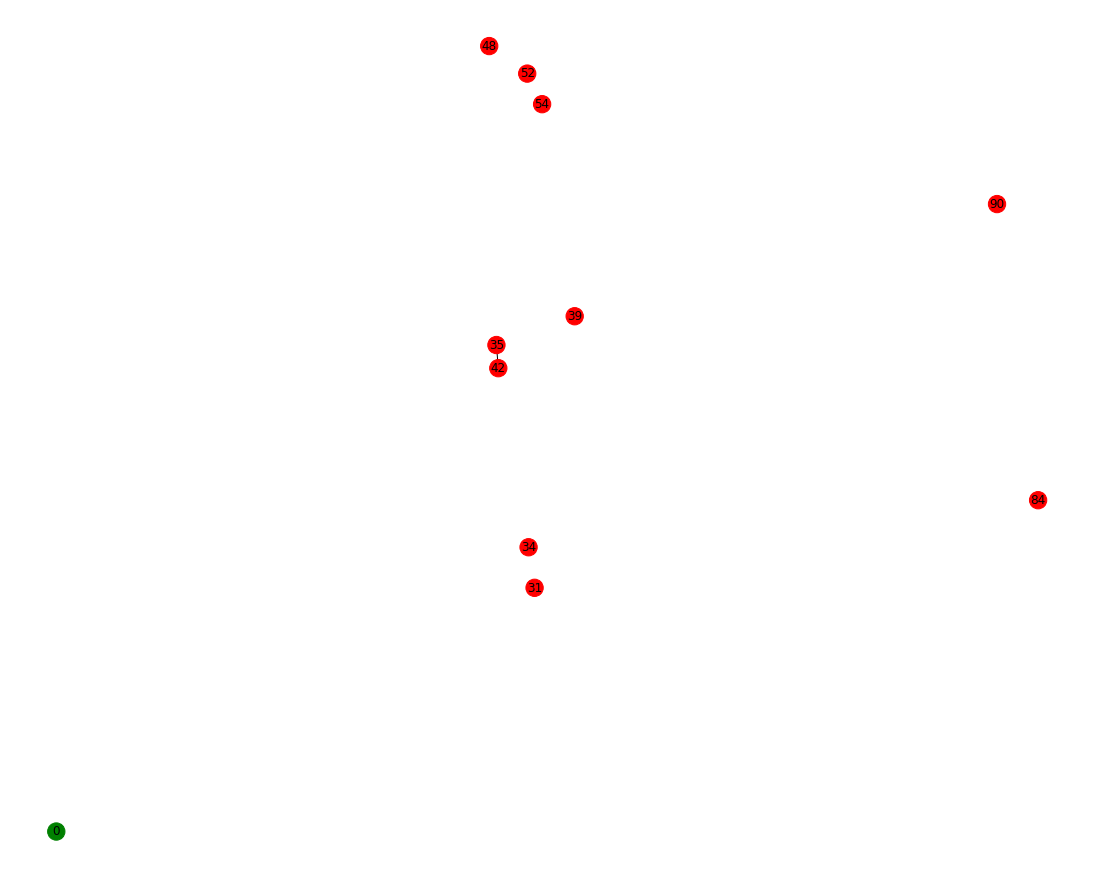

In [47]:
metrics.draw_compromised()

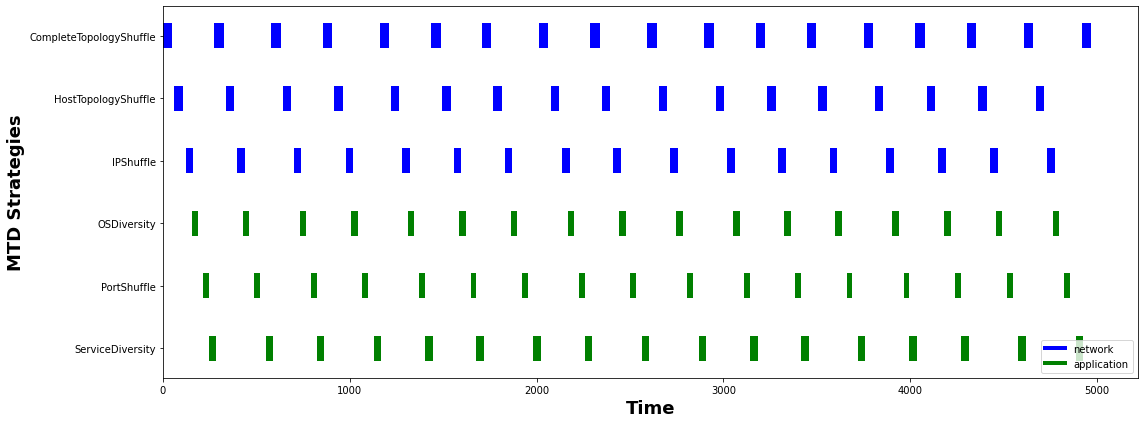

In [48]:
metrics.visualise_mtd_operation()

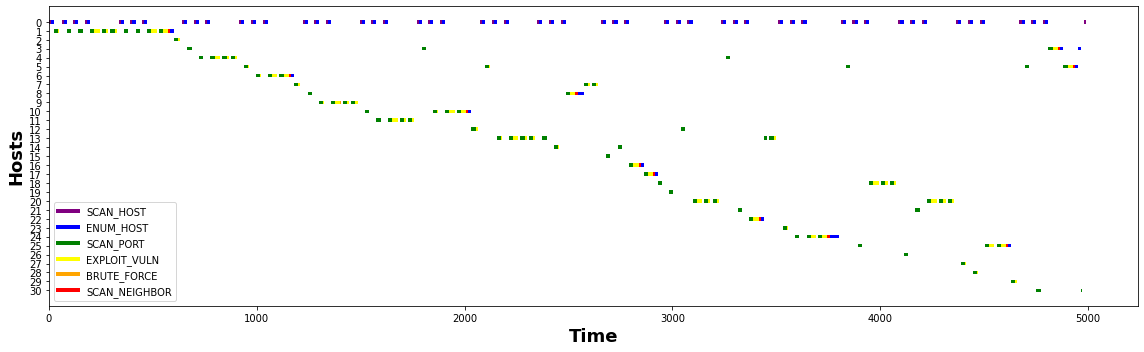

In [49]:
metrics.visualise_attack_operation_group_by_host()

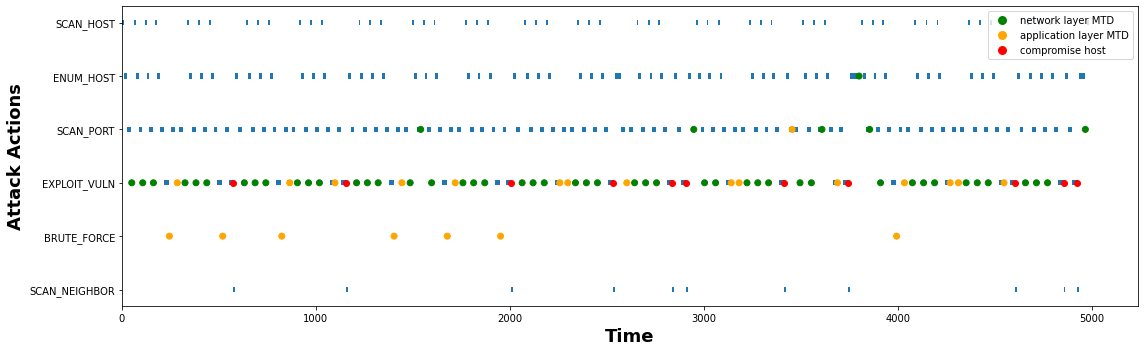

In [50]:
metrics.visualise_attack_operation()

In [51]:
metrics.compromise_record_by_attack_action('SCAN_PORT')

,name,start_time,finish_time,duration,current_host,current_host_uuid,compromise_host,compromise_host_uuid,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_users,interrupted_in,interrupted_by,color,curr_host_token


In [52]:
metrics.compromise_record_by_attack_action('EXPLOIT_VULN')

,name,start_time,finish_time,duration,current_host,current_host_uuid,compromise_host,compromise_host_uuid,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_users,interrupted_in,interrupted_by,color,curr_host_token
35,EXPLOIT_VULN,549.611964,574.687929,25.075964,0,39fc9388-c0ac-4c1b-8181-044d5a20fece,0,39fc9388-c0ac-4c1b-8181-044d5a20fece,7,6,0,"[Jordanna, Nissie, Fredra, Walliw, Della]",None,None,yellow,1
70,EXPLOIT_VULN,1128.553028,1153.920558,25.367530,27,9804b435-f2a8-42a7-88fb-748cca53b14e,27,9804b435-f2a8-42a7-88fb-748cca53b14e,2,33,1,"[Nert, Adoree, Adrian, Jeane, Caryl]",None,None,yellow,6
122,EXPLOIT_VULN,1982.622202,2007.939126,25.316925,39,2675cf1e-4b4a-48f5-b88a-42a056076903,39,2675cf1e-4b4a-48f5-b88a-42a056076903,4,66,2,"[Mab, Merlina, Anallise, Rosmunda, Nettie]",None,None,yellow,10
154,EXPLOIT_VULN,2507.191328,2533.167004,25.975676,26,e7a04ee5-8994-4972-a027-7e5967ff6836,26,e7a04ee5-8994-4972-a027-7e5967ff6836,1,70,3,"[Alleen, Cherey, Druci, Zuzana, Leila]",None,None,yellow,8
173,EXPLOIT_VULN,2811.875885,2837.039521,25.163636,40,96d82d1d-4714-46c0-9b28-e04a6cf0a008,40,96d82d1d-4714-46c0-9b28-e04a6cf0a008,1,113,4,"[Goldy, Kerry, Veronica, Georgeanne, Ezmeralda]",None,None,yellow,16
177,EXPLOIT_VULN,2882.039521,2907.217891,25.178370,63,df6b3481-30ab-4b8f-9179-8407955efa0a,63,df6b3481-30ab-4b8f-9179-8407955efa0a,1,129,5,"[Suzann, Siana, Melony]",None,None,yellow,17
208,EXPLOIT_VULN,3389.672158,3415.276748,25.604591,35,3c4fc9b1-5984-454e-8a4c-b646b76fce2b,35,3c4fc9b1-5984-454e-8a4c-b646b76fce2b,1,170,6,"[Mallory, Eleanora, Kitty, Malissa]",None,None,yellow,22
226,EXPLOIT_VULN,3719.907672,3745.719267,25.811594,32,39d0b9b1-94e8-4209-bfbe-88424ba3a003,32,39d0b9b1-94e8-4209-bfbe-88424ba3a003,2,200,7,"[Nikaniki, Anjanette, Milli, Christy]",None,None,yellow,24
277,EXPLOIT_VULN,4578.950606,4603.990768,25.040163,45,13a66aff-bf05-4cce-9e99-8e5cc6bbe731,45,13a66aff-bf05-4cce-9e99-8e5cc6bbe731,1,210,8,"[Merilyn, Phillida, Vikky, Una, Leoine]",None,None,yellow,25
293,EXPLOIT_VULN,4828.248517,4855.598104,27.349587,31,9f6deab5-7b1e-46c6-8906-122318e34944,31,9f6deab5-7b1e-46c6-8906-122318e34944,2,213,9,"[Becca, Rosene, Rozelle, Pippy]",None,None,yellow,3


In [53]:
metrics.compromise_record_by_attack_action('BRUTE_FORCE')

,name,start_time,finish_time,duration,current_host,current_host_uuid,compromise_host,compromise_host_uuid,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_users,interrupted_in,interrupted_by,color,curr_host_token


In [54]:
metrics.mean_time_to_compromise()

109.00576335286146

In [55]:
metrics.mtd_execution_frequency()

0.020731595694266435

In [56]:
metrics.attack_success_rate()

0.36666666666666664